In [48]:
#import necessary libraries
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
# for image datasets
from keras.preprocessing.image import ImageDataGenerator
# Data Visualization
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
#layers to add to the model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization,Conv2D
from tensorflow.keras.models import Model
#optimizers
from tensorflow.keras.optimizers import SGD, Adam
#for evaluation
from sklearn.metrics import classification_report, confusion_matrix
#for long warnings
import warnings


warnings.filterwarnings('ignore')



In [49]:
#train data
train_dir =("/Users/Hand_data/train/")
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)

# Class Distribution
class_dis = [len(os.listdir(train_dir + name)) for name in class_names]

# Show_classnames
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 2 
Class Names : ['Normal_hand ', 'Tremor_hand']


In [54]:
# Visualize training distribution
fig = px.bar(x=class_names, y=class_dis, title="Training Class Distribution", color=class_names)
fig.update_layout({'title': {'x': 0.5}})

# Show the plot in Jupyter Notebook using different renderers
fig.show(renderer="iframe") 

In [55]:
#validation data
test_dir =("/Users/Hand_data/valid/")
class_names = sorted(os.listdir(test_dir))
n_classes = len(class_names)

# Class Distribution
class_dis = [len(os.listdir(test_dir + name)) for name in class_names]


# Show
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 2 
Class Names : ['Normal_hand ', 'Tremor_hand']


In [56]:
# Visualize tesing class distribution
fig = px.bar(x=class_names, y=class_dis, title="Testing Class Distribution", color=class_names)
fig.update_layout({'title': {'x': 0.5}})

# Show the plot in Jupyter Notebook using different renderers
fig.show(renderer="iframe") 

In [16]:
# create the data generators with data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale = 1./255,

    


  )

test_datagen = ImageDataGenerator(rescale = 1./255)

train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 274 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


In [17]:
#sample images
def show_images(data, class_names=None, size=(30, 30), grid=[5,5]):
    # Get a batch of images and labels from the generator
    images, labels = next(iter(data))

    # Get the number of rows and columns in the grid
    n_cols = grid[1] if grid else min(3, images.shape[0])
    n_images = min(4 * n_cols, images.shape[0])
    n_rows = 4

    # Create the grid and plot the images with their labels
    fig, ax = plt.subplots(n_rows, n_cols, figsize=size)
    for i in range(n_rows):
        for j in range(n_cols):
            idx = i * n_cols + j
            if idx < n_images:
                img = images[idx]
                label = class_names[np.argmax(labels[idx])] if class_names else None
                ax[i][j].imshow(img)
                ax[i][j].set_title("Class:" + label)
                ax[i][j].axis('off')
    plt.show()



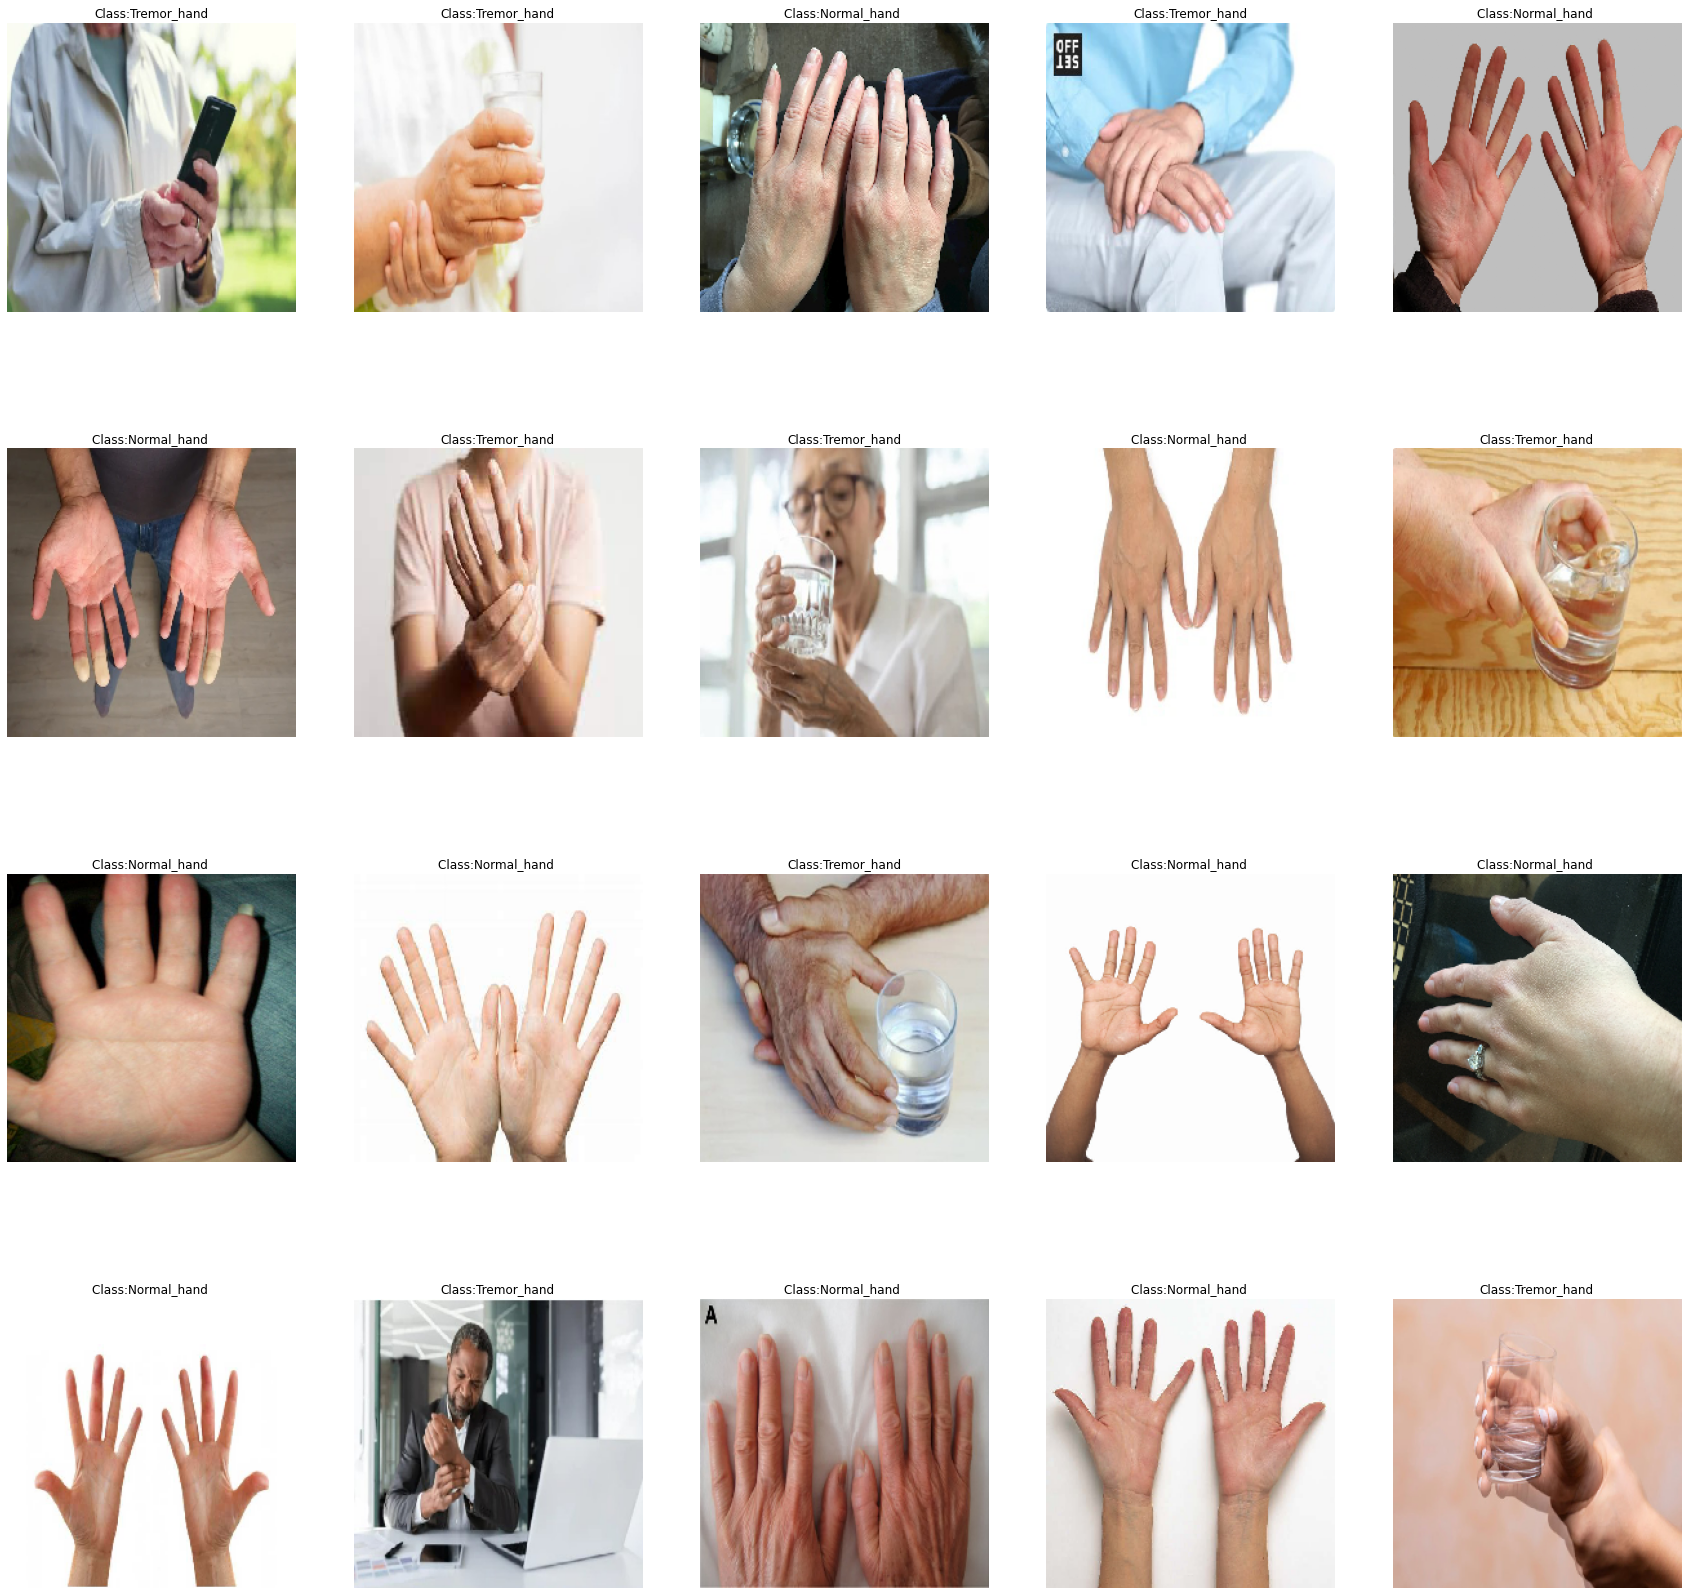

In [18]:
#train images
show_images(train_ds, class_names)

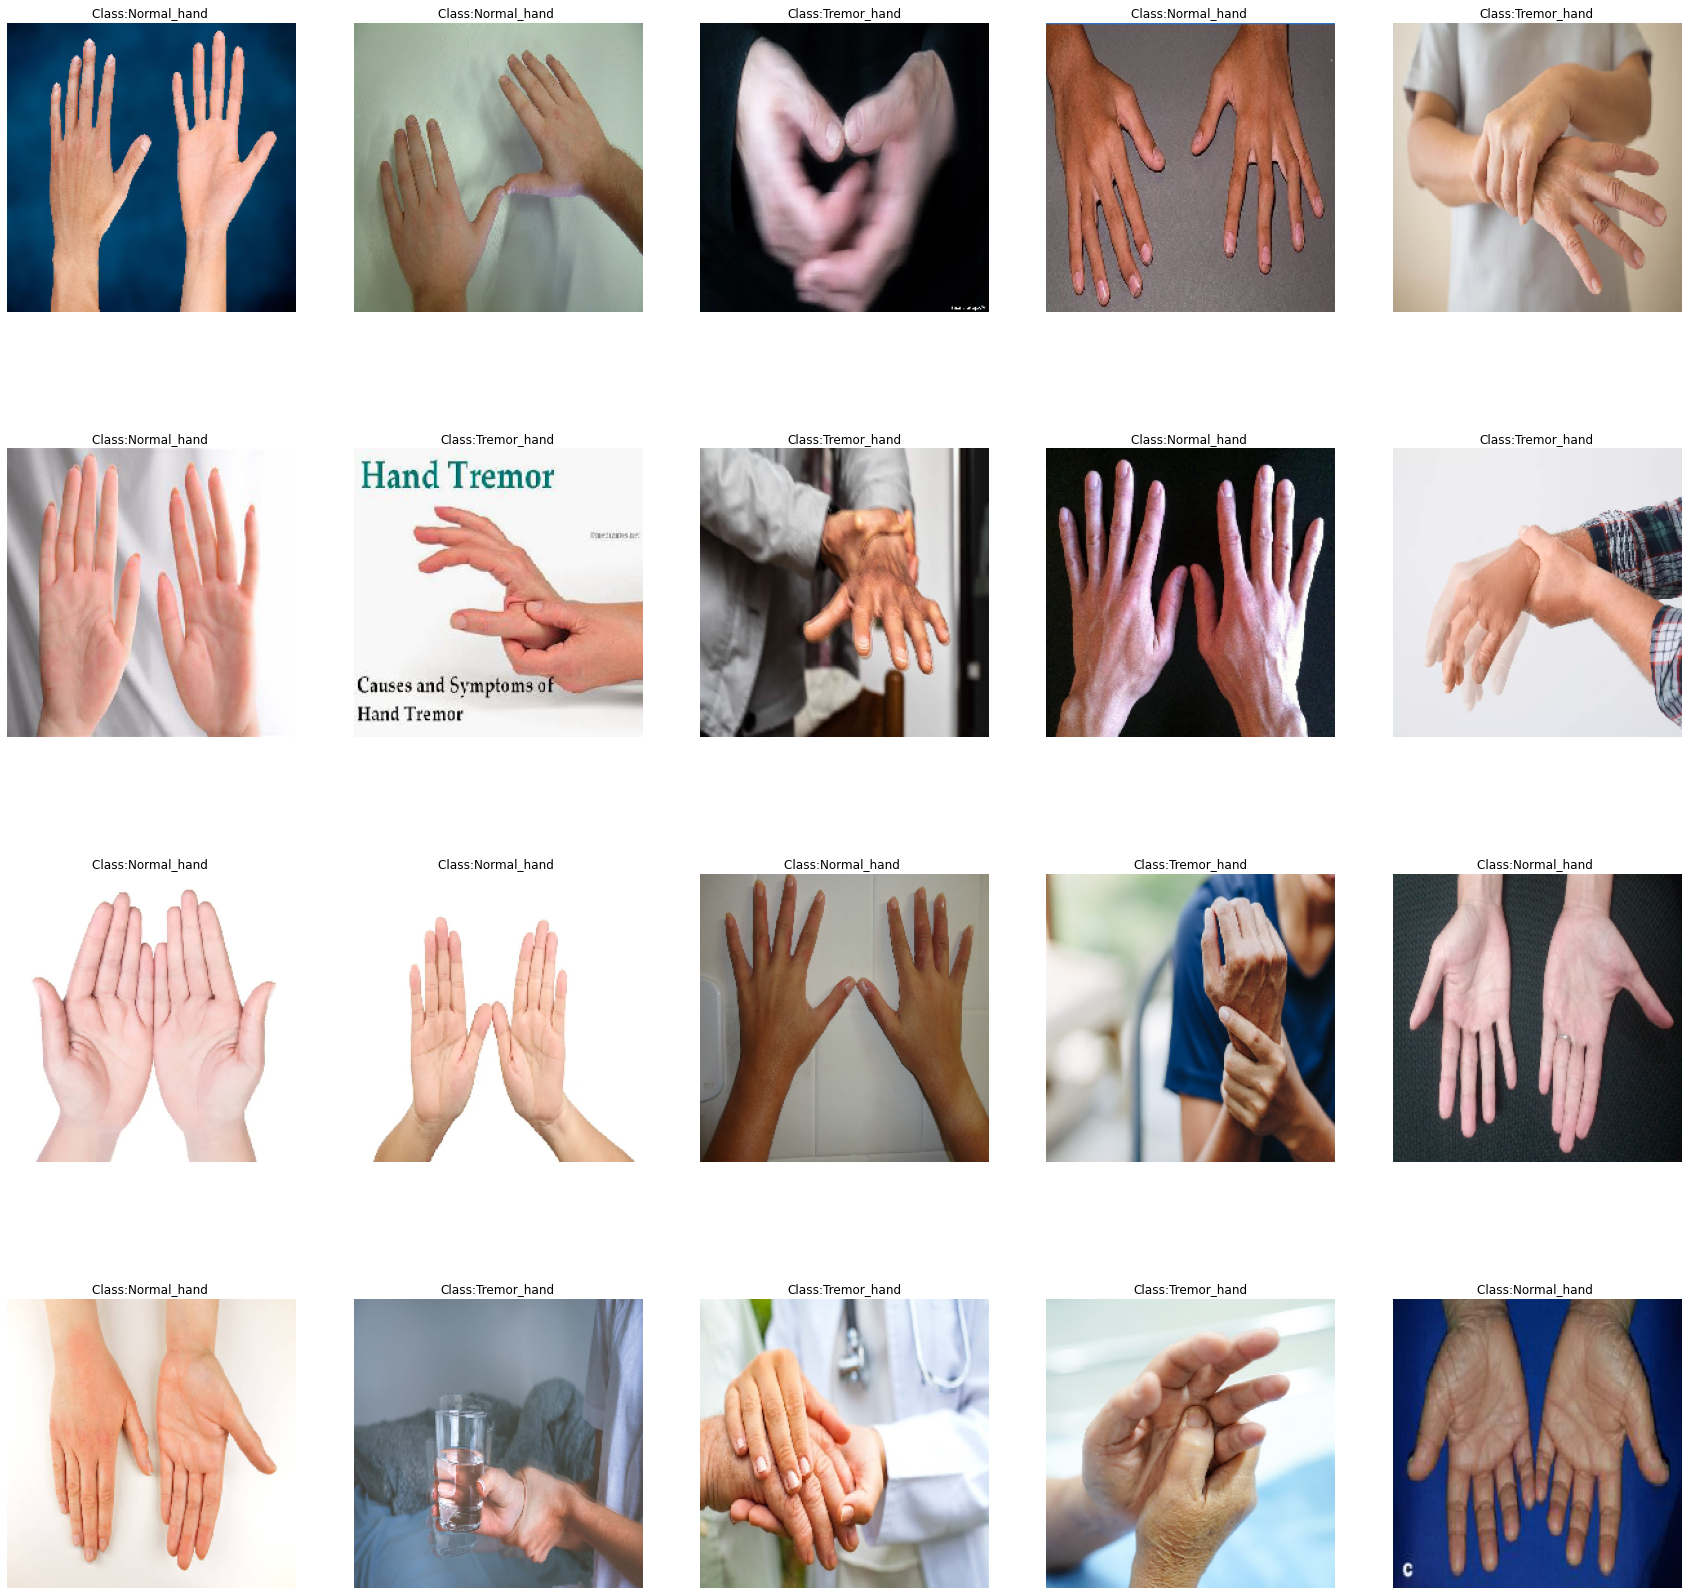

In [19]:
#validation images
show_images(test_ds, class_names)

In [20]:
# define the hyperparameters
batch_size = 32
epochs =50
#learning_schedule
initial_learning_rate=0.0001
decay_steps=10000
decay_rate=0.01
dropout_rate = 0.5
num_classes = 2

In [21]:
# load the pre-trained Xception model with imagenet weights
base_model = tf.keras.applications.xception.Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224, 224, 3)
)

In [22]:
# freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

In [23]:
# add a new output layer with a softmax activation function
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(train_ds.num_classes, activation='softmax')(x)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
# predictions = Dense(train_ds.num_classes, activation='softmax')(x)
# for layer in base_model.layers[-20:]:
#     layer.trainable = True
# create the final model for fine-tuning
model = Model(inputs = base_model.input, outputs = predictions)


# define the optimizer and compile the model with loss function, metrics, and optimizer
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=10000,
    decay_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizer,
    metrics = ['accuracy', 'Precision', 'Recall']
)

# print the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'

In [24]:
# train the model on the training data with fine-tuning of all layers
history = model.fit(
    train_ds,
    epochs = 50,
    validation_data = test_ds,
    steps_per_epoch = len(train_ds),
    validation_steps = len(test_ds),
    # callbacks = [
    #     tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
    #     tf.keras.callbacks.ModelCheckpoint('/Users/Hand_data/model', save_best_only = True)
    # ]
    
)

Epoch 1/50


2024-01-03 23:23:35.897434: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


9/9 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.5657 - precision: 0.5657 - recall: 0.5657

2024-01-03 23:23:58.023217: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


9/9 [==============================] - 26s 3s/step - loss: 0.6906 - accuracy: 0.5657 - precision: 0.5657 - recall: 0.5657 - val_loss: 0.6608 - val_accuracy: 0.6154 - val_precision: 0.6154 - val_recall: 0.6154
Epoch 2/50
9/9 [==============================] - 22s 3s/step - loss: 0.6740 - accuracy: 0.6058 - precision: 0.6058 - recall: 0.6058 - val_loss: 0.6366 - val_accuracy: 0.6731 - val_precision: 0.6731 - val_recall: 0.6731
Epoch 3/50
9/9 [==============================] - 23s 3s/step - loss: 0.6701 - accuracy: 0.5985 - precision: 0.5985 - recall: 0.5985 - val_loss: 0.6148 - val_accuracy: 0.6731 - val_precision: 0.6731 - val_recall: 0.6731
Epoch 4/50
9/9 [==============================] - 23s 3s/step - loss: 0.6254 - accuracy: 0.7153 - precision: 0.7153 - recall: 0.7153 - val_loss: 0.5936 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 5/50
9/9 [==============================] - 23s 3s/step - loss: 0.6156 - accuracy: 0.7117 - precision: 0.7117 - recall: 0.711

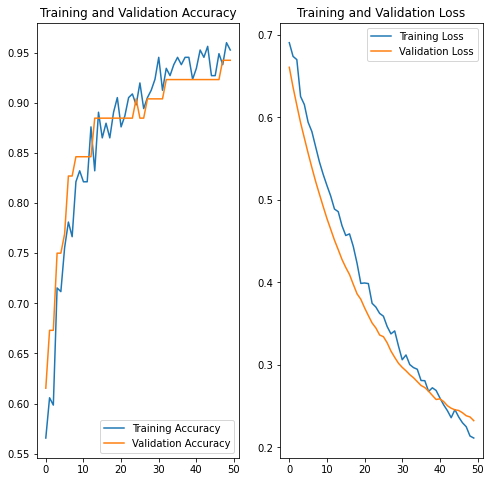

In [25]:
#visualizing the performance of our model to check for overfitting visually

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)
plt.figure(figsize=(8, 8))

# ​figure 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
# figure 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


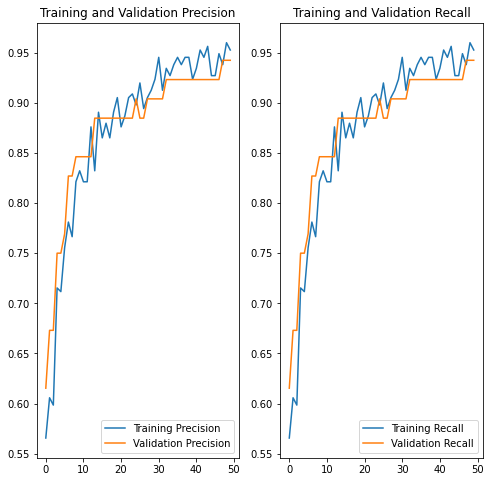

In [26]:
#for precision and recall
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']
epochs_range = range(50)
plt.figure(figsize=(8, 8))



#figure 3
plt.subplot(1, 2, 1)
plt.plot(epochs_range, precision, label='Training Precision')
plt.plot(epochs_range, val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

#figure 4
plt.subplot(1, 2, 2)
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.show()

## Checking Prediction results

Found 52 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step


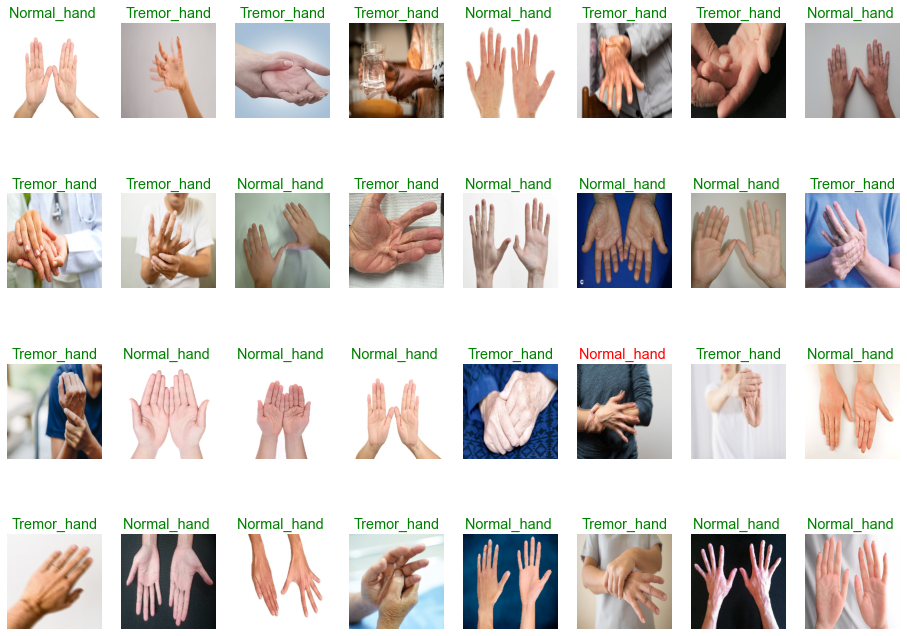

In [30]:
testdir = "/Users/Hand_data/valid/"

tes_datagen = ImageDataGenerator(rescale=1./255)

test = tes_datagen.flow_from_directory(
    testdir,
    target_size = (224, 224)

)
target_names = list(test.class_indices.keys())
# take a few images of test_ds to predict our model
image_batch, label_batch = next((test))

# predict on the batch
predicted_batch = model.predict(image_batch)

# get the predicted class indices
predicted_ids = np.argmax(predicted_batch, axis=-1)

# map the indices to the class names
predicted_class_names = [target_names[id] for id in predicted_ids]

# get the true class names
true_class_names = [target_names[id] for id in np.argmax(label_batch, axis=-1)]

# plot the images with the predicted and true class names
plt.figure(figsize=(16, 12))
for i in range(len(image_batch)):
    plt.subplot(4, 8, i+1)
    plt.imshow(image_batch[i])
    color = 'green' if predicted_class_names[i] == true_class_names[i] else 'red'
    plt.title(predicted_class_names[i], color=color)
    plt.axis('off')
plt.show()

In [31]:
# get the integer labels
true_labels = np.argmax(label_batch, axis=-1)

# get the predicted labels
predicted_labels = np.argmax(predicted_batch, axis=-1)

# checking accuracy of our model
from sklearn.metrics import accuracy_score
accuracy_score(true_labels, predicted_labels)

0.96875

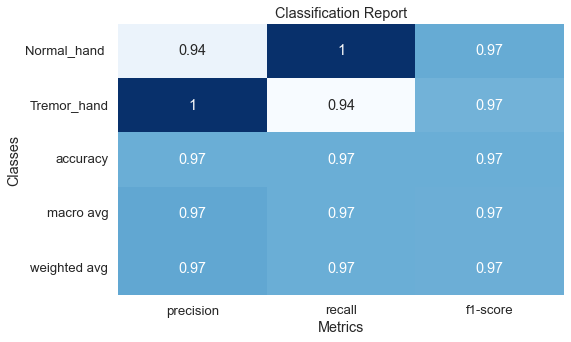

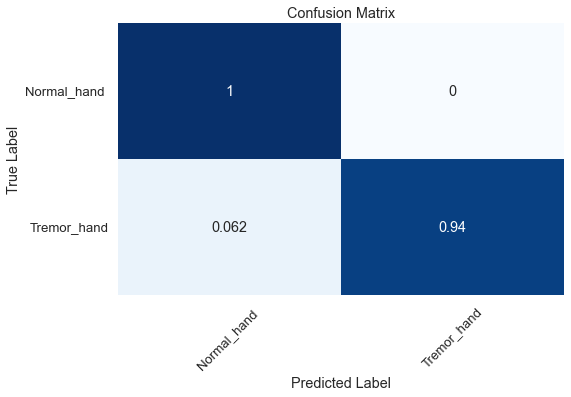

In [33]:
#Define a function to generate the color-coded classification report
def color_code_report(y_true, y_pred, target_names):
    # Generate the classification report
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

    # Create a color-coded heatmap of the classification report
    sns.set(font_scale=1.2)
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues', cbar=False, ax=ax)
    ax.set_title('Classification Report')
    ax.set_ylabel('Classes')
    ax.set_xlabel('Metrics')

    # Return the classification report as a dictionary
    return report

# Define a function to generate the color-coded confusion matrix
def color_code_confusion_matrix(y_true, y_pred, target_names):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a color-coded heatmap of the confusion matrix
    sns.set(font_scale=1.2)
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(cm_norm, annot=True, cmap='Blues', cbar=False, ax=ax)
    ax.set_title('Confusion Matrix')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_xticklabels(target_names, rotation=45)
    ax.set_yticklabels(target_names, rotation=0)

    # Return the confusion matrix as a numpy array
    return cm

# Generate color-coded evaluation report
report = color_code_report(true_labels, predicted_labels, target_names)
# Generate color-coded confusion matrix
cm = color_code_confusion_matrix(true_labels, predicted_labels, target_names)
